# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

## Predict Salary based on the job descriptions.
Job descriptions could have various attributes for the same :
1.) Job Type : Role /  Position for the Job ( Ex : Executive / Management / Fresher / Mid Level Roles etc.) 
2.) Degree of Education required for the job ( Ex :  Masters / PHD / Bachelors etc. )
3.) Field of Study / Major ( Ex : Math /  Computer Science / Biology etc. )
4.) Industry ( Ex : Textile /  Automobile / Technology / Health etc. )
5.) Years of Experience
6.) Miles from Metropolis / How far from the main city  

In [72]:
#import libraries
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt

#info
__author__ = "MD ASIF AKHTER"
__email__ = "akhter.asif@gmail.com"

## Part 2 - DISCOVER

In [73]:
# Find the Current Directory
import os
print(os.getcwd())

C:\Users\A


### ---- 2 Load the data ----

In [74]:
#load the data into a Pandas dataframe
train_features = pd.read_csv("train_features.csv")
print(train_features.head())

              jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  
0   HEALTH               10                   83  
1      WEB                3                   73  
2   HEALTH               10                   38  
3     AUTO                8                   17  
4  FINANCE                8                   16  


In [75]:
train_salaries = pd.read_csv("train_salaries.csv")
print(train_salaries.head())

              jobId  salary
0  JOB1362684407687     130
1  JOB1362684407688     101
2  JOB1362684407689     137
3  JOB1362684407690     142
4  JOB1362684407691     163


In [76]:
test_features = pd.read_csv("test_features.csv")
print(test_features.head())

              jobId companyId  jobType       degree    major industry  \
0  JOB1362685407687    COMP33  MANAGER  HIGH_SCHOOL     NONE   HEALTH   
1  JOB1362685407688    COMP13   JUNIOR         NONE     NONE     AUTO   
2  JOB1362685407689    COMP10      CTO      MASTERS  BIOLOGY   HEALTH   
3  JOB1362685407690    COMP21  MANAGER  HIGH_SCHOOL     NONE      OIL   
4  JOB1362685407691    COMP36   JUNIOR     DOCTORAL  BIOLOGY      OIL   

   yearsExperience  milesFromMetropolis  
0               22                   73  
1               20                   47  
2               17                    9  
3               14                   96  
4               10                   44  


In [77]:
print("Train Features Data has " + str(train_features.shape[0]) + " rows and " + str(train_features.shape[1]) + " columns" )
print("Train Salaries Data has " + str(train_salaries.shape[0]) + " rows and " + str(train_salaries.shape[1]) + " columns" )

#Looks like both the train data has equal number of records , we can join them.

train_data = pd.merge(train_features , train_salaries , on = 'jobId')

print("\n")
print(train_data.head())
print("\n")
print(train_data.shape)

Train Features Data has 1000000 rows and 8 columns
Train Salaries Data has 1000000 rows and 2 columns


              jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  salary  
0   HEALTH               10                   83     130  
1      WEB                3                   73     101  
2   HEALTH               10                   38     137  
3     AUTO                8                   17     142  
4  FINANCE                8                   16     163  


(1000000, 9)


### ---- 3 Clean the data ----

In [78]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

# Check for any salary less than 0 
train_data_salary_less_than_0 = train_data[train_data['salary'] <= 0]

print(len(train_data_salary_less_than_0))

# There are 5 records where salary is 0 , this could be corrupt data , we can drop them as they are very less compared 
# to the entire training set of 1 million records.

train_data = train_data.drop(train_data_salary_less_than_0.index.tolist())
print(train_data.shape)
      
# Check for duplicates 
train_data['is_duplicated'] = train_data.duplicated()
print(train_data['is_duplicated'].sum())

# The training data has no duplicates , hnece we need not drop any
# If duplicates , we could use df.drop_duplicates() to remove duplicates.

# Check for any other corrupt data / missing data
print("Missing Values : ")
print("\n")
print(train_data.isnull().sum())

5
(999995, 9)
0
Missing Values : 


jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
is_duplicated          0
dtype: int64


In [79]:
# Creating another copy, so that we can use one hot encoding in the future.
# Currently for EDA and  Visualization using category code values 
# Use One hot encoding for the model building as it will generate more features which could be helpful.
train_df = train_data.copy()

### ---- 4 Explore the data (EDA) ----

In [80]:
#summarize each feature variable
#summarize the target variable

# we can quickly check the summary for all the columns using the describe method

print('\n Summary :  \n')
print(train_data.describe(include='all'))

# Identify the Types of Each column
print("\n")
print(train_data.dtypes)

#look for correlation between each feature and the target

# for correlation we need to convert the category columns to  numeric
# In this data we have all these columns as object types - Job Id , Company Id , Job Type , Degree , Major , Industry
# Job ID and Company ID do not serve much purpose as they could be unique values for each job or each company

#convert categorical varibale to numeric values.
train_data['jobType'] = train_data['jobType'].astype('category').cat.codes #Job Type has 8 unique Values 
train_data['degree'] = train_data['degree'].astype('category').cat.codes # Degree has 5 Unique Values
train_data['major'] = train_data['major'].astype('category').cat.codes # Major has 9 Unique Values
train_data['industry'] = train_data['industry'].astype('category').cat.codes # Industry has 7 Unique Values

#Correlation between each feature and target 
print("\n Correlation : All Features vs Target \n")
print(train_data[train_data.columns[2:]].corr()['salary'][:])

#look for correlation between features 
print("\n Correlation : All Features vs Features \n")
print(train_data.corr()) # This will create the correlation matrix with all the features


 Summary :  

                   jobId companyId jobType       degree   major industry  \
count             999995    999995  999995       999995  999995   999995   
unique            999995        63       8            5       9        7   
top     JOB1362685181948    COMP39  SENIOR  HIGH_SCHOOL    NONE      WEB   
freq                   1     16193  125886       236975  532353   143205   
mean                 NaN       NaN     NaN          NaN     NaN      NaN   
std                  NaN       NaN     NaN          NaN     NaN      NaN   
min                  NaN       NaN     NaN          NaN     NaN      NaN   
25%                  NaN       NaN     NaN          NaN     NaN      NaN   
50%                  NaN       NaN     NaN          NaN     NaN      NaN   
75%                  NaN       NaN     NaN          NaN     NaN      NaN   
max                  NaN       NaN     NaN          NaN     NaN      NaN   

        yearsExperience  milesFromMetropolis         salary is_duplicate

In [81]:

# Drop Columns 
# We do not need job id , company id , isduplicated flag as they dont serve any purpose further.

train_data = train_data.drop(columns = ['jobId' , 'companyId' , 'is_duplicated'])
print(train_data.head())

   jobType  degree  major  industry  yearsExperience  milesFromMetropolis  \
0        1       3      6         3               10                   83   
1        0       2      7         6                3                   73   
2        7       1      8         3               10                   38   
3        5       1      2         0                8                   17   
4        7       0      8         2                8                   16   

   salary  
0     130  
1     101  
2     137  
3     142  
4     163  


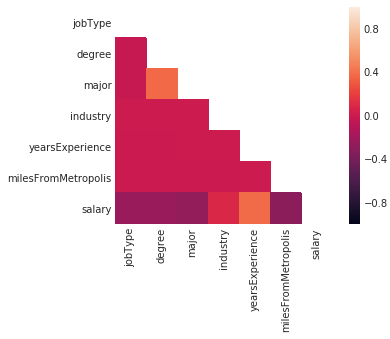

In [82]:
# Visualize the correlation matrix 

# Use Seaborn Heatmap 
import seaborn as sns

corr = train_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, square=True)

In [83]:
# One Hot Encoding 

# There are few categorical values in the data and we do not have any orderly relationship within the category codes.
# Use One hot encoding so that machine learning model performs better

train_jobtype = pd.get_dummies(train_df['jobType'])
train_degree = pd.get_dummies(train_df['degree'])
train_major = pd.get_dummies(train_df['major'])
train_industry = pd.get_dummies(train_df['industry'])


train_df = train_df.drop(columns = ['jobType' , 'degree' , 'major' ,'industry' ])

train_df_final = pd.concat([train_df[['yearsExperience','milesFromMetropolis']] , train_jobtype , train_degree , train_major , train_industry , train_df[['salary']]] , axis=1)
print(train_df_final.head())

   yearsExperience  milesFromMetropolis  CEO  CFO  CTO  JANITOR  JUNIOR  \
0               10                   83    0    1    0        0       0   
1                3                   73    1    0    0        0       0   
2               10                   38    0    0    0        0       0   
3                8                   17    0    0    0        0       0   
4                8                   16    0    0    0        0       0   

   MANAGER  SENIOR  VICE_PRESIDENT   ...    NONE  PHYSICS  AUTO  EDUCATION  \
0        0       0               0   ...       0        0     0          0   
1        0       0               0   ...       1        0     0          0   
2        0       0               1   ...       0        1     0          0   
3        1       0               0   ...       0        0     1          0   
4        0       0               1   ...       0        1     0          0   

   FINANCE  HEALTH  OIL  SERVICE  WEB  salary  
0        0       1    0        0

In [84]:
# Correlation Matrix for the entire training data after one hot encoding

train_df_final_corr = train_df_final.corr()
print(train_df_final_corr)

                     yearsExperience  milesFromMetropolis       CEO       CFO  \
yearsExperience             1.000000             0.000672  0.000307 -0.000103   
milesFromMetropolis         0.000672             1.000000 -0.000666  0.000566   
CEO                         0.000307            -0.000666  1.000000 -0.142301   
CFO                        -0.000103             0.000566 -0.142301  1.000000   
CTO                         0.000967             0.000674 -0.142742 -0.142475   
JANITOR                    -0.001192            -0.001120 -0.142694 -0.142427   
JUNIOR                     -0.000001             0.001713 -0.142447 -0.142180   
MANAGER                    -0.000269            -0.000406 -0.142791 -0.142524   
SENIOR                      0.000222             0.000567 -0.143290 -0.143022   
VICE_PRESIDENT              0.000068            -0.001325 -0.142866 -0.142598   
BACHELORS                  -0.000407             0.000963  0.025655  0.025148   
DOCTORAL                    

### ---- 5 Establish a baseline ----

In [85]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

# Create a baseline  model with just industry , salary and salary_avg ( average salary for each industry ) and find MSE.
# use 5 fold cross validation

train_data_baseline = train_data[['industry','salary']]
train_data_baseline = train_data_baseline.set_index(['industry'])

mean_val = train_data_baseline.groupby('industry')['salary'].mean()

train_data_baseline['salary_avg'] = mean_val
train_data_baseline = train_data_baseline.reset_index()

print(train_data_baseline.head())

   industry  salary  salary_avg
0         3     130  115.735540
1         6     101  121.645362
2         3     137  115.735540
3         0     142  109.435222
4         2     163  130.747659


In [86]:
# Cross validation with 5 folds initial baseline model 

# Baseline model just has 1 feature ( salary ) and mean squared error is calculated with salary and average salary by industry
# This gives a very high MSE ( 1367 ) - average mse from 5 folds.
 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

X = train_data_baseline['industry']
y = train_data_baseline['salary']
y_baseline = train_data_baseline['salary_avg']

kf = KFold(n_splits=5) # Define the split - into 5 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 

mean_squared_err = []
k = 0 

for train_index, test_index in kf.split(X):
    k += 1
    print('\n Fold : ', k ,'\n')
    print("TRAIN:", train_index, "TEST:", test_index)
    
    y_train, y_test = y[train_index], y[test_index]
    y_base_train , y_base_test = y_baseline[train_index], y_baseline[test_index]
    
    error = mean_squared_error(y_test, y_base_test)
    print('MSE', error)
    mean_squared_err.append(error)
    
print('Average MSE', np.array(mean_squared_err).mean())

KFold(n_splits=5, random_state=None, shuffle=False)

 Fold :  1 

TRAIN: [199999 200000 200001 ... 999992 999993 999994] TEST: [     0      1      2 ... 199996 199997 199998]
MSE 1369.1806222423513

 Fold :  2 

TRAIN: [     0      1      2 ... 999992 999993 999994] TEST: [199999 200000 200001 ... 399995 399996 399997]
MSE 1368.6023543911754

 Fold :  3 

TRAIN: [     0      1      2 ... 999992 999993 999994] TEST: [399998 399999 400000 ... 599994 599995 599996]
MSE 1371.3591525123234

 Fold :  4 

TRAIN: [     0      1      2 ... 999992 999993 999994] TEST: [599997 599998 599999 ... 799993 799994 799995]
MSE 1362.2162691114431

 Fold :  5 

TRAIN: [     0      1      2 ... 799993 799994 799995] TEST: [799996 799997 799998 ... 999992 999993 999994]
MSE 1364.2563556689843
Average MSE 1367.1229507852554


### ---- 6 Hypothesize solution ----

In [87]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

Add more features , use the one hot encoding features dataframe and do a linear regression with more features.
2.) Use Polynomial Features.
3.) Use Random Forest Model

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.
Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [88]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

# Try model 1 ( linear regression with more features)


#y = train_df_final['salary']
X = train_df_final.drop(['salary'] , 1)
y = train_df_final[['salary']]

print(train_df_final.head())
print(type(X))
print(type(y))

   yearsExperience  milesFromMetropolis  CEO  CFO  CTO  JANITOR  JUNIOR  \
0               10                   83    0    1    0        0       0   
1                3                   73    1    0    0        0       0   
2               10                   38    0    0    0        0       0   
3                8                   17    0    0    0        0       0   
4                8                   16    0    0    0        0       0   

   MANAGER  SENIOR  VICE_PRESIDENT   ...    NONE  PHYSICS  AUTO  EDUCATION  \
0        0       0               0   ...       0        0     0          0   
1        0       0               0   ...       1        0     0          0   
2        0       0               1   ...       0        1     0          0   
3        1       0               0   ...       0        0     1          0   
4        0       0               1   ...       0        1     0          0   

   FINANCE  HEALTH  OIL  SERVICE  WEB  salary  
0        0       1    0        0

### ---- 8 Create models ----

In [89]:
#create and tune the models that you brainstormed during part 2

# make sure the data is scaled and all the data falls in the same scale ,
# so that the model doesnt treat some values differently , using minmax as the 
# value ranges from o to 1 and are not normally distributed.


from sklearn.preprocessing import MinMaxScaler
# data scaling

scaler = MinMaxScaler()
cols = X.columns

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=cols)

print(X_scaled.shape)
print(y.shape)
print(type(X_scaled))
print(type(y))

(999995, 31)
(999995, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### ---- 9 Test models ----

In [90]:
# do 5-fold cross validation on models and measure MSE
# Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


kf = KFold(n_splits=5) # Define the split - into 5 folds 
kf.get_n_splits(X_scaled) # returns the number of splitting iterations in the cross-validator
print(kf) 

X_scaled = np.nan_to_num(X_scaled)
y = np.nan_to_num(y)

mse = []
k =0
for train_index, test_index in kf.split(X_scaled):
    k += 1
    print('\nFold : ', k ,'\n')
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_linear_reg = LinearRegression().fit(X_train, y_train)
    y_pred = model_linear_reg.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    print('MSE', error)
    mse.append(error)
    
print('Average MSE', np.array(mse).mean())

KFold(n_splits=5, random_state=None, shuffle=False)

Fold :  1 

TRAIN: [199999 200000 200001 ... 999992 999993 999994] TEST: [     0      1      2 ... 199996 199997 199998]
MSE 386.3175723903217

Fold :  2 

TRAIN: [     0      1      2 ... 999992 999993 999994] TEST: [199999 200000 200001 ... 399995 399996 399997]
MSE 385.18601327564744

Fold :  3 

TRAIN: [     0      1      2 ... 999992 999993 999994] TEST: [399998 399999 400000 ... 599994 599995 599996]
MSE 385.99829824855607

Fold :  4 

TRAIN: [     0      1      2 ... 999992 999993 999994] TEST: [599997 599998 599999 ... 799993 799994 799995]
MSE 382.5725139532108

Fold :  5 

TRAIN: [     0      1      2 ... 799993 799994 799995] TEST: [799996 799997 799998 ... 999992 999993 999994]
MSE 382.0085928690828
Average MSE 384.41659814736374


In [91]:
# Polynomial Features with Linear Regression

from sklearn.preprocessing import PolynomialFeatures


kf = KFold(n_splits=5) # Define the split - into 5 folds 
kf.get_n_splits(X_scaled) # returns the number of splitting iterations in the cross-validator
print(kf) 

mse = []
k =0
for train_index, test_index in kf.split(X_scaled):
    k += 1
    print('\nFold', k ,'\n')
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    poly = PolynomialFeatures(2)
    poly = PolynomialFeatures(interaction_only=True)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.fit_transform(X_test)
    model_poly_lin_reg = LinearRegression()
    model_poly_lin_reg = model_poly_lin_reg.fit(X_poly_train, y_train)
    y_pred = model_poly_lin_reg.predict(X_poly_test)
    error = mean_squared_error(y_test, y_pred)
    print('MSE', error)
    mse.append(error)
    
print('Average MSE', np.array(mse).mean())

KFold(n_splits=5, random_state=None, shuffle=False)

Fold 1 

TRAIN: [199999 200000 200001 ... 999992 999993 999994] TEST: [     0      1      2 ... 199996 199997 199998]


MemoryError: 

In [92]:
# Random  Forest Regression

from sklearn.ensemble import RandomForestRegressor


kf = KFold(n_splits=5) # Define the split - into 5 folds 
kf.get_n_splits(X_scaled) # returns the number of splitting iterations in the cross-validator
print(kf) 

mse = []
k =0
for train_index, test_index in kf.split(X_scaled):
    k += 1
    print('\nFold', k ,'\n')
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_rfr = RandomForestRegressor(n_estimators = 250 , max_depth = 6 ).fit(X_train , y_train)
    y_pred = model_rfr.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    print('MSE', error)
    mse.append(error)
    
print('Average MSE', np.array(mse).mean())

KFold(n_splits=5, random_state=None, shuffle=False)

Fold 1 

TRAIN: [199999 200000 200001 ... 999992 999993 999994] TEST: [     0      1      2 ... 199996 199997 199998]


C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


MSE 651.4057270174435

Fold 2 

TRAIN: [     0      1      2 ... 999992 999993 999994] TEST: [199999 200000 200001 ... 399995 399996 399997]


C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


MSE 649.455990082062

Fold 3 

TRAIN: [     0      1      2 ... 999992 999993 999994] TEST: [399998 399999 400000 ... 599994 599995 599996]


C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


MSE 647.693399919877

Fold 4 

TRAIN: [     0      1      2 ... 999992 999993 999994] TEST: [599997 599998 599999 ... 799993 799994 799995]


C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


MSE 639.4670800333699

Fold 5 

TRAIN: [     0      1      2 ... 799993 799994 799995] TEST: [799996 799997 799998 ... 999992 999993 999994]


C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


MSE 639.3490822191781
Average MSE 645.4742558543861


### ---- 10 Select best model  ----

In [93]:
#select the model with the lowest error as your "prodcuction" model

# Looks like the best model among the 3 models is using polynomial features in linear regression with degree 2

print(model_poly_lin_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

# Create pipeline so that we can do an end to end process
# read the data , clean the data , feature engineering 
# scaling and normalizing , build model 
# save the model to disk
# load the model to run on the test dataset and predict / calculate the scores accordingly.

X_train = pd.DataFrame(X_scaled , columns = X.columns)
y_train = pd.DataFrame(y , columns = ['salary'])


print(X_train.head())
print(X_train.shape)
print(type(X_train))


print(y_train.head())
print(y_train.shape)
print(type(y_train))

### ---- 12 Deploy solution ----

In [94]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

# Load Model 

model_load = joblib.load('model.pkl')

# Feature Eng and Clean the Test Data

# The test data should have same features as the train data features was modelled upon.

test_jobtype = pd.get_dummies(test_features_data['jobType'])
test_degree = pd.get_dummies(test_features_data['degree'])
test_major = pd.get_dummies(test_features_data['major'])
test_industry = pd.get_dummies(test_features_data['industry'])


test_df = test_features_data.drop(columns = ['jobId' , 'companyId' , 'jobType' , 'degree' , 'major' , 'industry'])

test_df_final = pd.concat([test_df[['yearsExperience','milesFromMetropolis']] , test_jobtype , test_degree , test_major , test_industry] , axis=1)
#print(test_df_final.head())

                           
# Scale the test data
test_cols = test_df_final.columns

X_test_scaled = scaler.fit_transform(test_df_final)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=test_cols)

#X_test_scaled = np.nan_to_num(X_test_scaled)
print(X_test_scaled.head())
print(X_test_scaled.shape)
print(type(X_test_scaled))

X_poly_test_all = poly.fit_transform(X_test_scaled)
final_res = model_load.predict(X_poly_test_all)

final_res_df = pd.DataFrame(final_res , columns = ['salary'])
print(final_res_df.head())

test_data = pd.concat([test_features_data , final_res_df],axis=1)
print(test_data.head())
print(test_data.shape)

test_data.to_csv('test_features_predicted.csv',index=False)

NameError: name 'joblib' is not defined

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data